In [1]:
from app_db_manager import AppDbManager
from query_helper import (
    APP_STORE_CATEGORY_CASE_STATEMENT,
    APP_STORE_CATEGORY_FILTER_STATEMENT,
    GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None)

In [3]:
db = AppDbManager()

__init__ function with app_store_file=appleAppData.csv, google_play_file=Google-Playstore.csv


In [4]:
app_store_table_name = "app_store_apps_table"
google_play_table_name = "google_play_apps_table"

In [5]:
print(APP_STORE_CATEGORY_CASE_STATEMENT)
print(APP_STORE_CATEGORY_FILTER_STATEMENT)
print(GOOGLE_PLAY_CATEGORY_CASE_STATEMENT)
print(GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT)


CASE
    WHEN category = 'Games' THEN 'Game'
    WHEN category = 'Music' THEN 'Music'
    WHEN category = 'Health & Fitness' THEN 'Health'
END


category IN ('Games', 'Music', 'Health & Fitness')


CASE
    WHEN category IN ('Games', 'Action', 'Adventure', 'Arcade',
                      'Board', 'Card', 'Casino, Casual',
                      'Educational', 'Music', 'Puzzle', 'Racing',
                      'Role Playing', 'Simulation', 'Sports',
                      'Strategy', 'Trivia', 'Word') THEN 'Game'
    WHEN category = 'Music & Audio' THEN 'Music'
    WHEN category = 'Health & Fitness' THEN 'Health'
END


category IN ('Games', 'Action', 'Adventure', 'Arcade',
                      'Board', 'Card', 'Casino, Casual',
                      'Educational', 'Music', 'Puzzle', 'Racing',
                      'Role Playing', 'Simulation', 'Sports',
                      'Strategy', 'Trivia', 'Word', 'Music & Audio', 'Health & Fitness')



## Plot the distribution of app sizes across our three categories.

In [6]:
query_1_1 = """
SELECT
    {case_statement} AS category,
    MIN(size_in_mb) AS min_size,
    AVG(size_in_mb) AS avg_size,
    MAX(size_in_mb) AS max_size
FROM {table_name}
WHERE {filter_statement}
GROUP BY 1
"""

In [7]:
# app store
result_1_apple = db.run_select_pd(query_1_1.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
))

In [8]:
result_1_apple

,category,min_size,avg_size,max_size
0,Game,0.000000,142.563163,73222.591724
1,Health,0.143153,63.638878,6351.762695
2,Music,0.026348,73.180113,5087.920526


In [9]:
# google play
result_1_google = db.run_select_pd(query_1_1.format(
    case_statement=GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    filter_statement=GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
    table_name=google_play_table_name,
))

In [10]:
result_1_google

,category,min_size,avg_size,max_size
0,Game,0.009766,30.556361,1536.0
1,Health,0.007520,28.802659,706.0
2,Music,0.008887,17.923657,1126.4


In [11]:
query_1_hist = """
SELECT
    {case_statement} AS category,
    CASE
        WHEN size_in_mb > {max_size} THEN {max_size}
        ELSE size_in_mb
    END AS size_in_mb
FROM {table_name}
WHERE {filter_statement}
"""

In [12]:
# app store
bin_size_apple = 100
max_size_apple = bin_size_apple * 10
result_1_apple = db.run_select_pd(query_1_hist.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
    max_size=max_size_apple
))


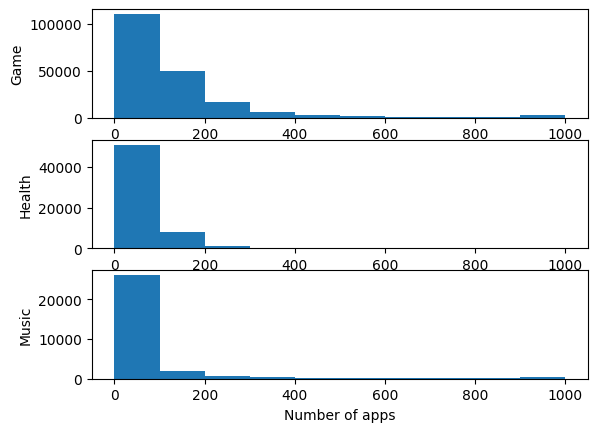

In [13]:
bins = list(range(0, max_size_apple+bin_size_apple, bin_size_apple))
fig, ax = plt.subplots(3,1)
ax[0].hist(result_1_apple[result_1_apple.category=='Game'].size_in_mb, bins)
ax[0].set_ylabel('Game')
ax[1].hist(result_1_apple[result_1_apple.category=='Health'].size_in_mb, bins)
ax[1].set_ylabel('Health')
ax[2].hist(result_1_apple[result_1_apple.category=='Music'].size_in_mb, bins)
ax[2].set_ylabel('Music')
ax[2].set_xlabel('Number of apps')
plt.show()

In [14]:
# google play
bin_size_google = 30
max_size_google = bin_size_google * 10
result_1_google = db.run_select_pd(query_1_hist.format(
    case_statement=GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    filter_statement=GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
    table_name=google_play_table_name,
    max_size=max_size_google
))

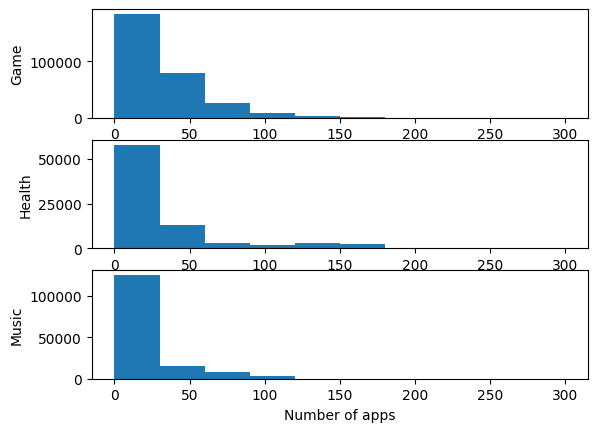

In [15]:
bins = list(range(0, max_size_google+bin_size_google, bin_size_google))
fig, ax = plt.subplots(3,1)
ax[0].hist(result_1_google[result_1_google.category=='Game'].size_in_mb, bins)
ax[0].set_ylabel('Game')
ax[1].hist(result_1_google[result_1_google.category=='Health'].size_in_mb, bins)
ax[1].set_ylabel('Health')
ax[2].hist(result_1_google[result_1_google.category=='Music'].size_in_mb, bins)
ax[2].set_ylabel('Music')
ax[2].set_xlabel('Number of apps')
plt.show()

## Compute the average rating across all ratings for each of the three categories.

In [16]:
query_2 = """
SELECT
    {case_statement} AS category,
    SUM(rating*rating_count) * 1.0 / SUM(rating_count) AS average_rating
FROM {table_name}
WHERE {filter_statement}
GROUP BY 1
"""

In [17]:
# app store
result_2_apple = db.run_select_pd(query_2.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
))

In [18]:
result_2_apple

,category,average_rating
0,Game,4.620479
1,Health,4.754431
2,Music,4.767138


In [19]:
# google play
result_2_google = db.run_select_pd(query_2.format(
    case_statement=GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    filter_statement=GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
    table_name=google_play_table_name,
))

In [20]:
result_2_google

,category,average_rating
0,Game,4.272284
1,Health,4.474643
2,Music,4.387132


## Plot the number of new releases in each category over time by month

In [21]:
query_3 = """
SELECT
    {case_statement} AS category,
    SUBSTR(released_date, 1, 7) AS released_month,
    count(1) AS cnt
FROM {table_name}
WHERE {filter_statement}
GROUP BY 1, 2
ORDER BY 1, 2
"""

In [22]:
# app store
result_3_apple = db.run_select_pd(query_3.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
))

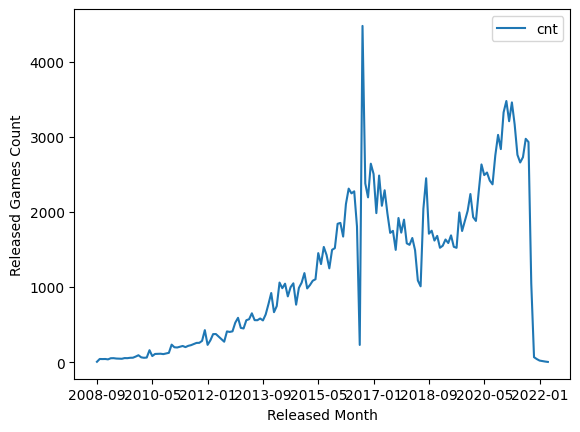

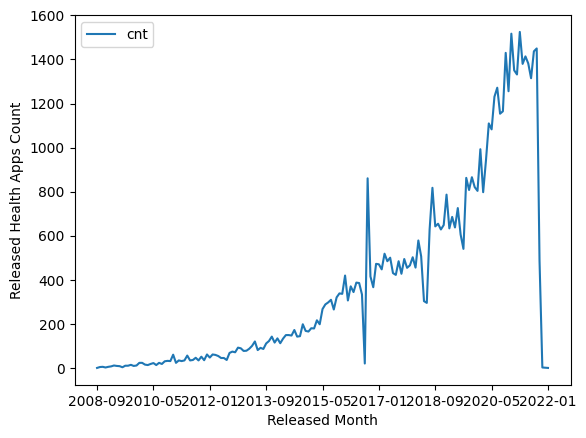

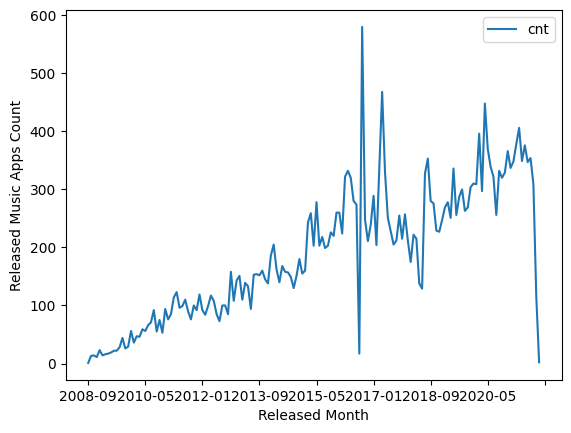

In [23]:
pd_3_apple_game = result_3_apple[result_3_apple.category=='Game'].dropna()
pd_3_apple_health = result_3_apple[result_3_apple.category=='Health'].dropna()
pd_3_apple_music = result_3_apple[result_3_apple.category=='Music'].dropna()
pd_3_apple_game.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Games Count")
plt.show()
pd_3_apple_health.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Health Apps Count")
plt.show()
pd_3_apple_music.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Music Apps Count")
plt.show()

confirmed from the raw data:

2016-05|9657

2016-06|10257

2016-07|8092

2016-08|783

2016-09|21206

2016-10|11257

2016-11|10388

2016-12|11851

2017-01|11846

2017-02|9819

2017-03|12192

2017-04|10469

2017-05|71

In [24]:
# google play
result_3_google = db.run_select_pd(query_3.format(
    case_statement=GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    filter_statement=GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
    table_name=google_play_table_name,
))

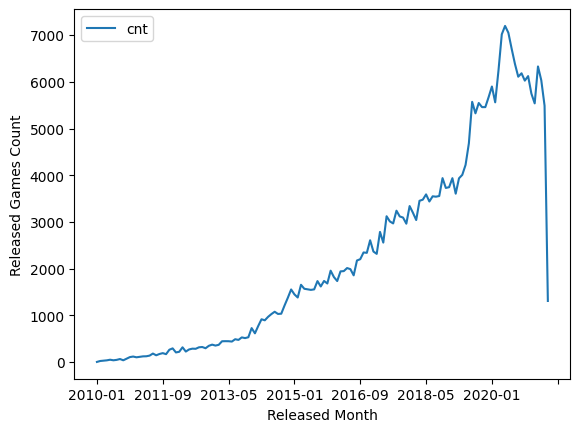

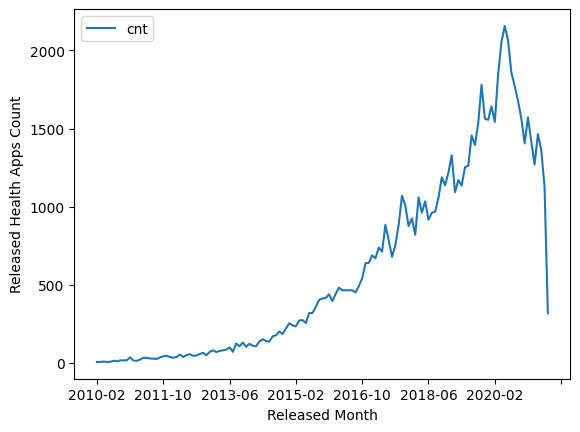

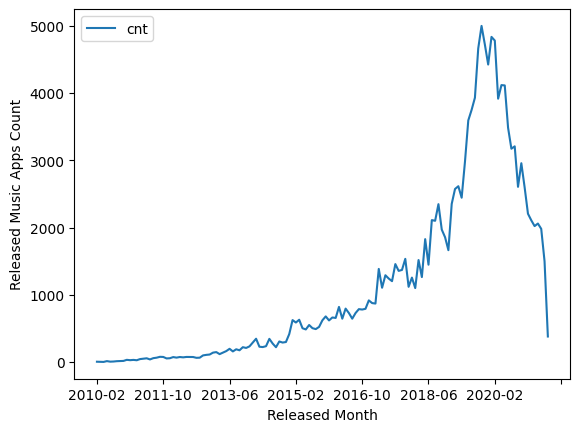

In [25]:
pd_3_google_game = result_3_google[result_3_google.category=='Game'].dropna()
pd_3_google_health = result_3_google[result_3_google.category=='Health'].dropna()
pd_3_google_music = result_3_google[result_3_google.category=='Music'].dropna()
pd_3_google_game.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Games Count")
plt.show()
pd_3_google_health.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Health Apps Count")
plt.show()
pd_3_google_music.plot(x="released_month", y="cnt")
plt.xlabel("Released Month")
plt.ylabel("Released Music Apps Count")
plt.show()

## List the 10 biggest apps by size in each category by year.

In [26]:
query_4 = """
WITH max_size_by_category_by_year AS (
    SELECT
        DISTINCT
        {case_statement} AS new_category,
        SUBSTR(released_date, 1, 4) AS released_year,
        size_in_mb,
        RANK() OVER (
            PARTITION BY {case_statement}, SUBSTR(released_date, 1, 4)
            ORDER BY size_in_mb DESC) AS size_rank
    FROM {table_name}
    WHERE {filter_statement}
)
SELECT
    max_size_by_category_by_year.new_category AS category,
    SUBSTR(released_date, 1, 4) AS released_year,
    raw.app_name,
    raw.app_id,
    raw.size_in_mb
FROM {table_name} as raw
INNER JOIN max_size_by_category_by_year
    ON max_size_by_category_by_year.new_category = {case_statement}
    AND max_size_by_category_by_year.released_year = SUBSTR(raw.released_date, 1, 4)
    AND max_size_by_category_by_year.size_in_mb <= raw.size_in_mb
    AND max_size_by_category_by_year.size_rank = 10
ORDER BY 1, 2, 5 DESC
"""

In [27]:
# app store
result_4_apple = db.run_select_pd(query_4.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
))

In [28]:
result_4_apple[result_4_apple.category=='Game']

,category,released_year,app_name,app_id,size_in_mb
0,Game,2008,QBeez,com.skunkstudios.games.QBeez,253.416016
1,Game,2008,PAC-MAN,com.namconetworks.pacmanlite,210.491211
2,Game,2008,Kroll,com.dle.kroll,200.907869
3,Game,2008,Solitaire Classic ©,com.companyname.BMLite,172.075195
4,Game,2008,Soccer Physics - free online foosball skill fr...,ru.idigger.fblite,150.086914
5,Game,2008,Checkers ・,R6WLZBVJLW.CheckersFree,118.766602
6,Game,2008,Backgammon - Classic Dice Game,com.trivialtechnology.BackgammonLite,114.958008
7,Game,2008,Crazy Snowboard,com.ezone.Snowboard,98.872070
8,Game,2008,Deep Green Chess,com.cocoastuff.deepgreen,94.563477
9,Game,2008,Iron Fist Boxing,com.realtechvr.ironfistboxing,93.884766


In [29]:
result_4_apple[result_4_apple.category=='Health']

,category,released_year,app_name,app_id,size_in_mb
150,Health,2008,Map My Ride by Under Armour,Q5AWL8WCY6.iMapMyRide,242.536133
151,Health,2008,Map My Fitness by Under Armour,Q5AWL8WCY6.iMapMyFitness,239.965820
152,Health,2008,Map My Run by Under Armour,Q5AWL8WCY6.iMapMyRun,239.403320
153,Health,2008,First Aid White Cross,my.company.iFirstAid,193.860352
154,Health,2008,Lose It! – Calorie Counter,com.fitnow.loseit,184.162109
155,Health,2008,White Noise Lite,com.tmsoft.WhiteNoiseLite,94.017578
156,Health,2008,Menstrual Calendar FMC,com.tamtris.menstrualcalendar,32.087891
157,Health,2008,Interval Run,fi.deltavee.RunnerLite,26.309570
158,Health,2008,Cures A-Z,com.plumamazing.naturalcures,19.388672
159,Health,2008,Gluten Free Restaurant Cards,com.doron.GFCard,18.645508


In [30]:
result_4_apple[result_4_apple.category=='Music']

,category,released_year,app_name,app_id,size_in_mb
290,Music,2008,Capital FM,com.thisisglobal.CapitalFM,228.415039
291,Music,2008,Deezer: Music & Podcast Player,com.deezer.Deezer,131.972656
292,Music,2008,Holiday Bells,HolidayBells,117.810547
293,Music,2008,Christmas,com.xmeinc.christmas,107.705078
294,Music,2008,Sonos S1 Controller,com.sonos.SonosController,107.688477
295,Music,2008,Cadena 100,es.cadena100.eple,106.034180
296,Music,2008,FourTrack,com.sonomawireworks.FourTrack,100.505859
297,Music,2008,Songs of Love,org.songsoflove.SongsOfLoveApp,79.479492
298,Music,2008,ANTENNE BAYERN,de.antenne.eple,55.920898
299,Music,2008,ROCK ANTENNE,de.rockantenne.eple,54.147461


In [31]:
# google play
result_4_google = db.run_select_pd(query_4.format(
    case_statement=GOOGLE_PLAY_CATEGORY_CASE_STATEMENT,
    filter_statement=GOOGLE_PLAY_CATEGORY_FILTER_STATEMENT,
    table_name=google_play_table_name,
))

In [32]:
result_4_google[result_4_google.category=='Game']

,category,released_year,app_name,app_id,size_in_mb
0,Game,2010,"Yahoo Fantasy Sports: Football, Baseball & More",com.yahoo.mobile.client.android.fantasyfootball,330.0
1,Game,2010,Tour Tempo Golf - Total Game,com.return7.tourtempo,112.0
2,Game,2010,Angry Birds Seasons,com.rovio.angrybirdsseasons,100.0
3,Game,2010,Angry Birds Classic,com.rovio.angrybirds,99.0
4,Game,2010,GolfLogix GPS + Putt Line,com.golflogix.ui,97.0
5,Game,2010,Zynga Poker ™: Free Texas Holdem Online Card G...,com.zynga.livepoker,97.0
6,Game,2010,Atlanta Falcons Mobile,com.yinzcam.nfl.falcons,93.0
7,Game,2010,BattleBears Zombies,com.skyvu.battlebearszombies,92.0
8,Game,2010,FC Red Bull Salzburg App,laola.redbull,91.0
9,Game,2010,TUDN: Univision Deportes Network,com.july.univision,86.0


In [33]:
result_4_google[result_4_google.category=='Health']

,category,released_year,app_name,app_id,size_in_mb
100,Health,2010,"Insight Timer - Meditation, Sleep, Music",com.spotlightsix.zentimerlite2,131.0
101,Health,2010,Quit Smoking with Andrew Johnson,com.hivebrain.andrewjohnson.smoking,127.0
102,Health,2010,Beat Social Phobia with Andrew Johnson,com.hivebrain.andrewjohnson.phobia2,122.0
103,Health,2010,Stop Drinking with Andrew Johnson,com.hivebrain.andrewjohnson.drinking,102.0
104,Health,2010,Move On with Andrew Johnson,com.hivebrain.andrewjohnson.moveon,97.0
105,Health,2010,Positivity with Andrew Johnson,com.hivebrain.andrewjohnson.positivity,94.0
106,Health,2010,Positive Pregnancy with Andrew Johnson,com.hivebrain.andrewjohnson.pregnancy,93.0
107,Health,2010,Stress Free with Andrew Johnson,com.hivebrain.andrewjohnson.stressfree,92.0
108,Health,2010,"Calorie Counter - MyNetDiary, Food Diary Tracker",com.fourtechnologies.mynetdiary.ad,90.0
109,Health,2010,Resuscitate!,org.learncpr.videoapp,85.0


In [34]:
result_4_google[result_4_google.category=='Music']

,category,released_year,app_name,app_id,size_in_mb
171,Music,2010,Vocal Ease,com.oncue.android.vocalease,130.0
172,Music,2010,QQMusic,com.tencent.qqmusic,98.0
173,Music,2010,"SoundCloud - Play Music, Podcasts & New Songs",com.soundcloud.android,87.0
174,Music,2010,radio ffn. Wir sind Niedersachsen.,com.warptec.ioneaffn,57.0
175,Music,2010,NML,com.naxos.nml,51.0
176,Music,2010,XS Manchester,com.thisisaim.rockradio,48.0
177,Music,2010,DS audio,com.synology.DSaudio,46.0
178,Music,2010,KCRW,com.kcrw,38.0
179,Music,2010,Rock en Seine Festival 2020,com.greencopper.android.rockenseine2010,34.0
180,Music,2010,MusicID,com.gravitymobile.recognize,33.0


## some checks

In [77]:
query_4_check = """
    SELECT
        {case_statement} AS new_category,
        SUBSTR(released_date, 1, 4) AS released_year,
        app_name,
        size_in_mb
    FROM {table_name}
    WHERE {filter_statement}
        AND SUBSTR(released_date, 1, 4) = '2008'
        AND category IN ('Health & Fitness') -- , 'Music', ''
    ORDER BY size_in_mb DESC
    LIMIT 10
"""

In [78]:
# app store
result_4_apple_check = db.run_select_pd(query_4_check.format(
    case_statement=APP_STORE_CATEGORY_CASE_STATEMENT,
    filter_statement=APP_STORE_CATEGORY_FILTER_STATEMENT,
    table_name=app_store_table_name,
))

In [79]:
result_4_apple_check

,new_category,released_year,app_name,size_in_mb
0,Health,2008,Map My Ride by Under Armour,242.536133
1,Health,2008,Map My Fitness by Under Armour,239.965820
2,Health,2008,Map My Run by Under Armour,239.403320
3,Health,2008,First Aid White Cross,193.860352
4,Health,2008,Lose It! – Calorie Counter,184.162109
5,Health,2008,White Noise Lite,94.017578
6,Health,2008,Menstrual Calendar FMC,32.087891
7,Health,2008,Interval Run,26.309570
8,Health,2008,Cures A-Z,19.388672
9,Health,2008,Gluten Free Restaurant Cards,18.645508
